In [95]:
# Load required Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import warnings
warnings.filterwarnings('ignore')

In [96]:
# Load in the data

df = pd.read_csv('UsArrests.csv')
df = df.set_index('City')
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.200,236,58,21.200
Alaska,10.000,263,48,44.500
Arizona,8.100,294,80,31.000
Arkansas,8.800,190,50,19.500
California,9.000,276,91,40.600


In [97]:
# Understanding the DataFrame

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [98]:
# Make numerical featurees all float types

df['Assault'] = df['Assault'].astype('float64')
df['UrbanPop'] = df['UrbanPop'].astype('float64')
df.dtypes

Murder      float64
Assault     float64
UrbanPop    float64
Rape        float64
dtype: object

In [99]:
#The describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.788,4.356,0.800,17.400
Assault,170.760,83.338,45.000,337.000
UrbanPop,65.540,14.475,32.000,91.000
Rape,21.232,9.366,7.300,46.000


Table shows Assualt stands out as having the highest mean

In [100]:
# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
Murder,0
Assault,0
UrbanPop,0
Rape,0


visualise the distribution of the observations for each feature:

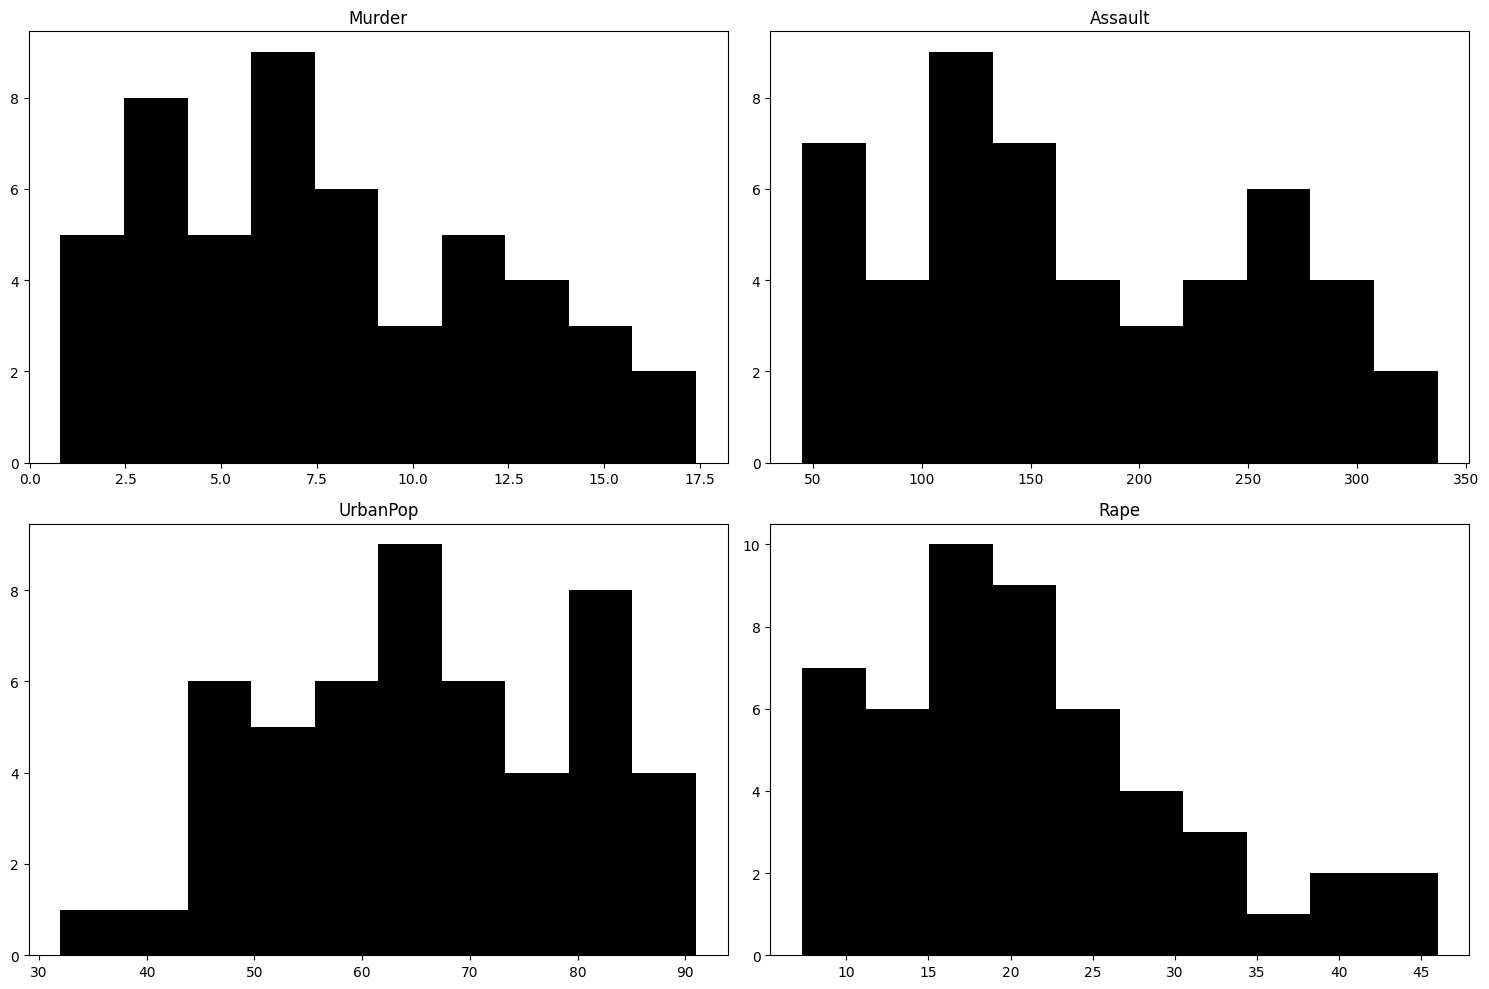

In [101]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(15, 10)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()

## Correlation Analysis

<AxesSubplot: >

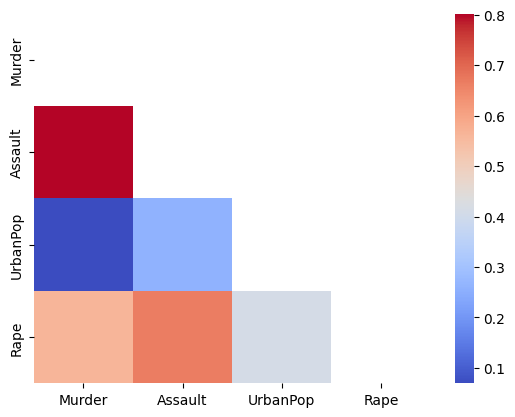

In [102]:
city = df.index
labels = df.columns
Arrest_corr = df.corr()
mask_ut=np.triu(np.ones(Arrest_corr.shape)).astype(np.bool)
sns.heatmap(Arrest_corr, mask=mask_ut, cmap="coolwarm")


In the plot, it shows murder and assault have strong positive correlations while murder and urbanpop have a strong negative correlations.

## PCA

In [103]:
np.set_printoptions(precision=2)

X = df.values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.802,11.448,-2.495,2.408
1,92.827,17.983,20.127,-4.094
2,124.068,-8.830,-1.687,-4.354
3,18.340,16.704,0.210,-0.521
4,107.423,-22.520,6.746,-2.812


In [104]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73 14.21  6.49  2.48]


In [105]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]


In [106]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


In [107]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = city[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

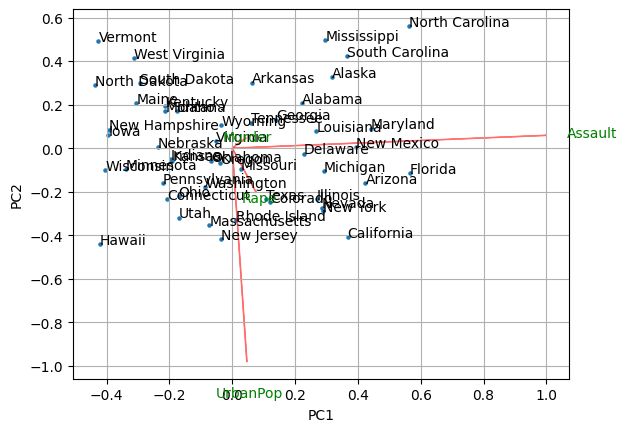

In [108]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(city))
plt.show()

In [109]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


Assault is the highest importance in the first principle component. UrbanPop is the highest importance in the second component. Refer to the summarised statistics from earlier on, the mean of assault is much larger than than the other features and the mean of urbanpop is relatively larger. It is possible that because of this, these features 'swamp' the others, which results in them being ignored.

## Standardised data

Standardise the data so that some features do not swamp the others.

In [110]:
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


In [111]:
std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


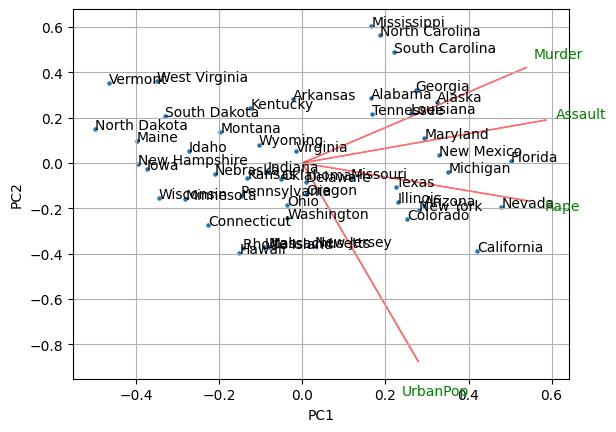

In [112]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

In [113]:
# Feature importance

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Inspecting the feature importance now, we see that most of the variables contribute fairly evenly, with only some with low importance.

Text(0.5, 1.0, 'Cumulative Explained Variance')

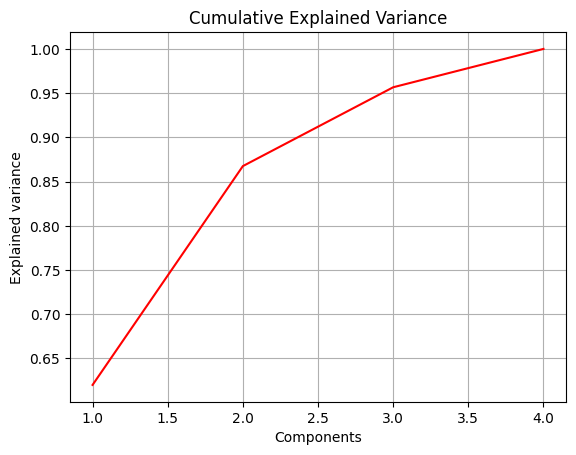

In [114]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.grid()
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

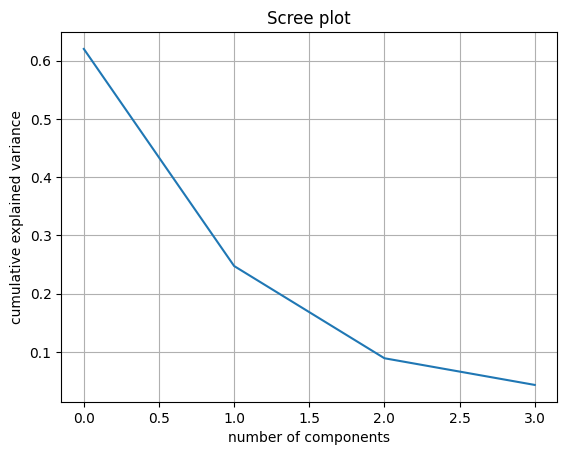

In [115]:
# Scree plot
plt.grid()
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The first 2 principal components together explain more than 85% of the variance. We can therefore use them to perform cluster analysis. 

In [116]:
pca_df = pd.DataFrame(X_std_trans[:,0:2], index = df.index)
pca_df.head()

,0,1
City,,
Alabama,0.986,1.133
Alaska,1.950,1.073
Arizona,1.763,-0.746
Arkansas,-0.141,1.120
California,2.524,-1.543


In [117]:
X = pca_df[[0,1]].values.reshape(-1,2)

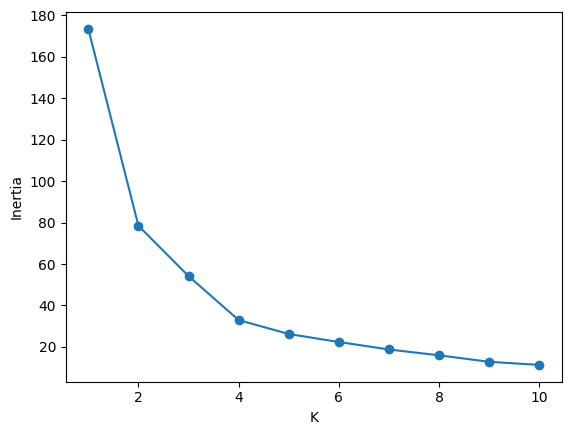

In [118]:
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r)
    kmeans.fit(x)    
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1,max_k+1)]
    plt.plot(range(1,11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

elbow_Kmeans(X)

The elbow start from 2 to 7, we will try k from 2 to 6.

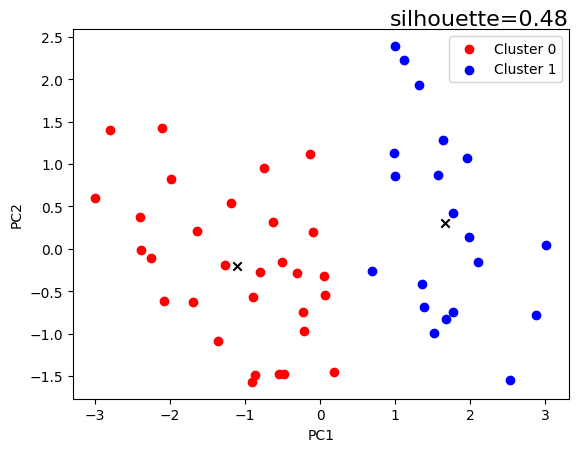

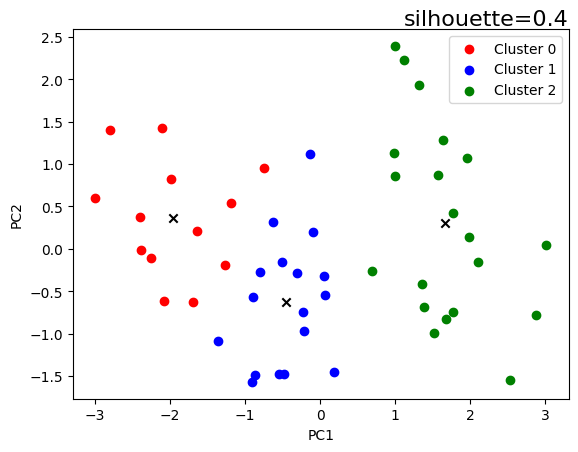

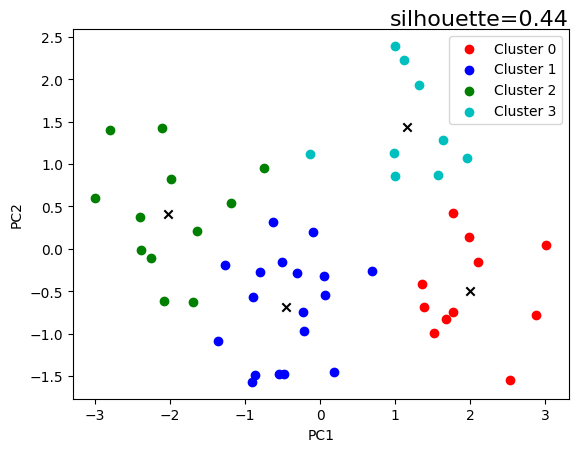

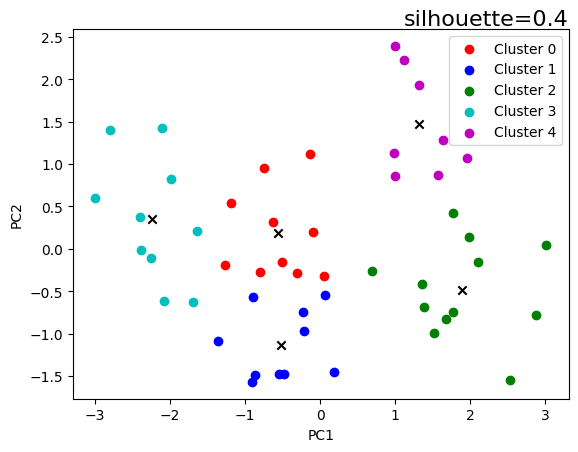

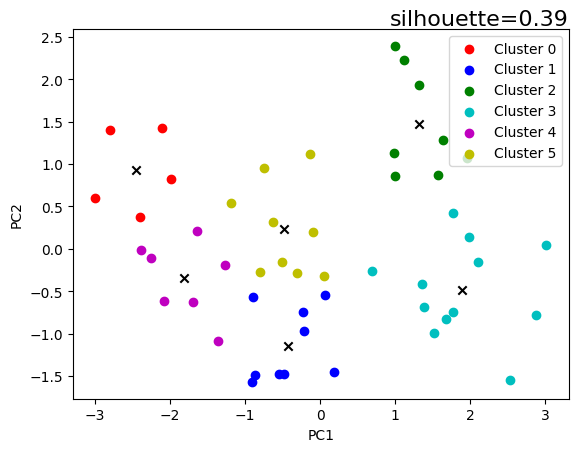

In [119]:
def scatter_Kmeans(x, k, r=123):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'
    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')

     
    score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'),2)
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.show()

for k in range(2,7):
  scatter_Kmeans(X, k, r=0)

The best silhouette score is actually achieved using k=2

## Hierarchical clustering

In [120]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

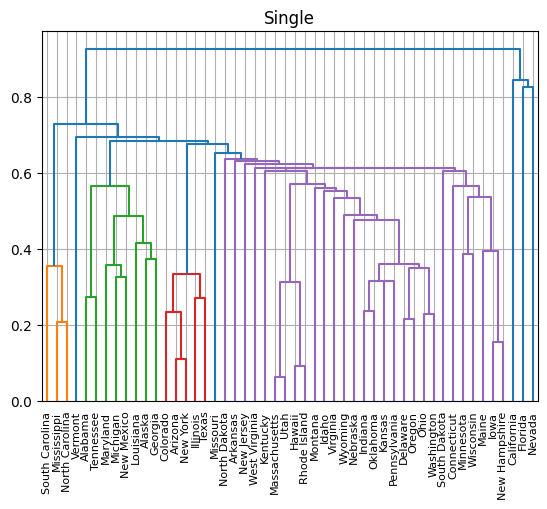

In [121]:
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index)
plt.grid()
plt.title("Single")
plt.show()

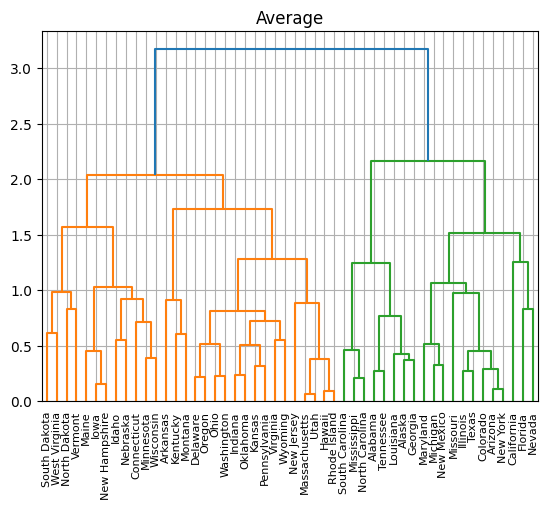

In [122]:
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index)
plt.grid()
plt.title("Average")
plt.show()

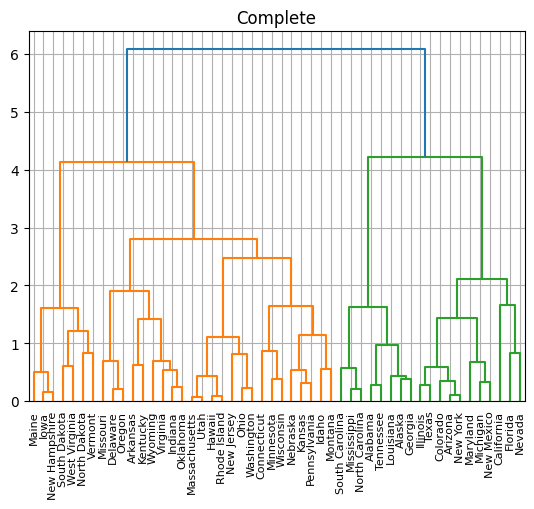

In [123]:
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.grid()
plt.title("Complete")
plt.show()

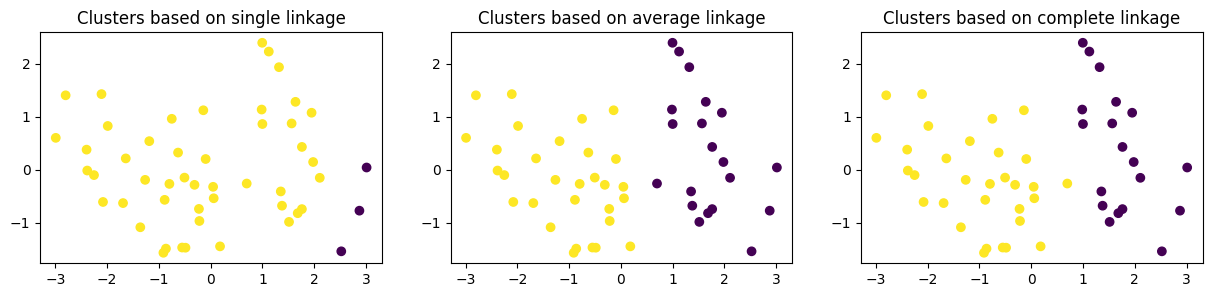

In [124]:
K = 2
X = pca_df[[0,1]].values.reshape(-1,2)
plt.figure(figsize=[15,3])

linkage_types = ['single', 'average', 'complete']

for i, l in enumerate(linkage_types):
  plt.subplot(1, 3, i+1)
  
  cluster = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage=l)
  cluster.fit_predict(X)

  ax = plt.scatter(X[:,0], X[:,1], c=cluster.labels_)
  
  plt.title('Clusters based on {} linkage'.format(l))

## Visualisation

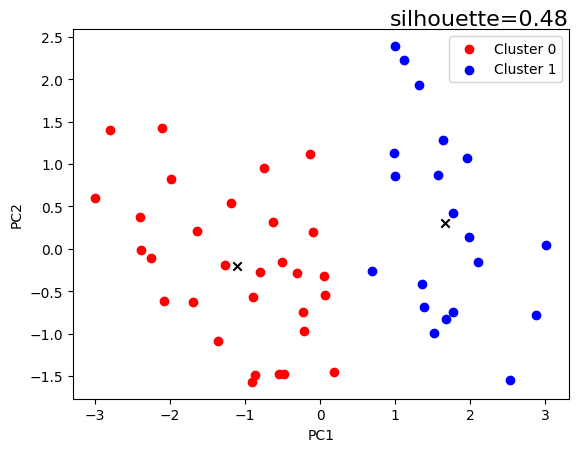

In [125]:
k = 2
X = pca_df[[0,1]].values.reshape(-1,2)
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=123)
y_pred = kmeans.fit_predict(X)
colours = 'rbgcmy'
for c in range(k):
    plt.scatter(X[y_pred == c, 0], X[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
    plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')

score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'),2)
plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


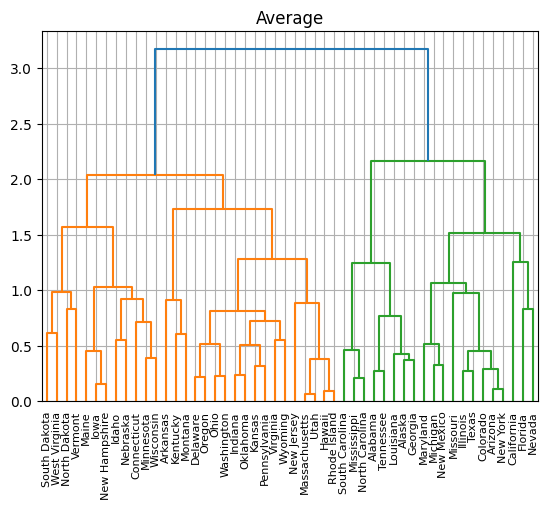

In [126]:
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index)
plt.grid()
plt.title("Average")
plt.show()

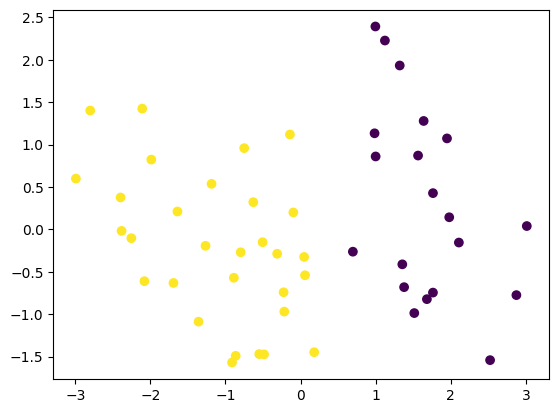

In [127]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')
cluster.fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=cluster.labels_)

In [128]:
# Verify the clusters using Silhouette score

from sklearn.metrics import silhouette_score

silhouette_value = silhouette_score(X, cluster.labels_)
print(f"Silhouette score: {silhouette_value:.3f}")

Silhouette score: 0.476


## Interpretation

The The data points in the left hand side belongs to the cities(states) have a relatively lower crime rate , while the data points in the right hand side belongs to the cities(states) have a relatively higher crime rate.